# Cross validation

## I) Imports

In [1]:
from proj1_helpers import *
from custom_helpers import *
from plot import *
from implementations import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## II) Required functions

In [2]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [24]:
def cross_validation(x, y, flag_method, degree, lambda_=0, gamma=0.001, max_iters=1000, k_fold=int(5), seed=143225):
    "Train the model and evaluate loss based on cross validation"
    mses_tr = []
    mses_te = []
    accuracy_tr = []
    accuracy_te = []
    
    flag_add_offset = True
    flag_standardize = True
    flag_remove_outliers = True
    
    k_indices = build_k_indices(y, k_fold, seed);
    for i in range(k_fold):
        newk_index = np.delete(k_indices, i, 0)
        indices_train = newk_index.ravel()
        indices_test = k_indices[i]

        # Train data at each iteration "i" of the loop
        x_train = x[indices_train]
        y_train = y[indices_train]

        # Validate the data at each iteration "i" of the loop
        x_test = x[indices_test]
        y_test = y[indices_test]

        # Prepare data (Standardisation and offset)
        training_tx, testing_tx = prepare_data(x_train, x_test, flag_add_offset, flag_standardize, flag_remove_outliers, degree)
        
        # create initial w for methods using it
        initial_w = np.zeros(training_tx.shape[1])

        if flag_method == 0:
            # Use linear regression (full gradient descent)
            weight, _ = least_squares_GD(y_train, training_tx, initial_w, max_iters, gamma)
            
        if flag_method == 1:
            # Use linear regression (stochastic gradient descent)
            weight, _ = least_squares_SGD(y_train, training_tx, initial_w, max_iters, gamma)
            
        if flag_method == 2:
            # Use least squares method
            weight, _ = least_squares(y_train, training_tx)
            
        if flag_method == 3:
            # Use ridge regression
            weight, _ = ridge_regression(y_train, training_tx, lambda_)
            
        if flag_method == 4:
            # Use logistic regression
            weight, _ = logistic_regression(y_train, training_tx, initial_w, max_iters, gamma)
            
        if flag_method == 5:
            # Use regularized logistic regression
            weight, _ = reg_logistic_regression(y_train, training_tx, initial_w, max_iters, gamma, lambda_)
            
        loss_te = np.sqrt(2 * compute_mse(y_test, testing_tx, weight))
        loss_tr = np.sqrt(2 * compute_mse(y_train, training_tx, weight))
        
        # Append loss of this round to list
        mses_tr.append(loss_tr)
        mses_te.append(loss_te)
        
        # calculate accuracy and add it to list
        y_pred_tr = predict_labels(weight, training_tx)
        y_pred_te = predict_labels(weight, testing_tx)
        accuracy_tr.append(np.sum(y_pred_tr == y_train)/len(y_train))
        accuracy_te.append(np.sum(y_pred_te == y_test)/len(y_test))


    mean_accuracy_tr = np.mean(accuracy_tr)
    mean_accuracy_te = np.mean(accuracy_te)
    loss_tr = np.mean(mses_tr)
    loss_te = np.mean(mses_te)
    return loss_tr, loss_te, mean_accuracy_tr, mean_accuracy_te

## III) Main
### Load the data

In [17]:
# Loading Data
print("Loading Data, please wait")
train_y, train_x, ids_train = load_csv_data('data/train.csv')
print("Data loaded, continue!!")

Loading Data, please wait
Data loaded, continue!!


In [ ]:
"""
Methods mapping
0    Linear regression (full gradient descent)
1    Linear regression (stochastic gradient descent)
2    Least squares method
3    Ridge regression
4    Logistic regression (stochastic gradient descent)
5    Regularized logistic regression (stochastic gradient descent)

"""

### Cross validation for one set of parameters only
Get the RMSE and accuracy for one method with defined parameters

In [31]:
# Chose learnig method to use (see mapping above)
flag_method = 2;
degree = 2
lambda_ = 0.0

# set Gradient descent parameters
gamma = 0.1
max_iters = 2500

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

_, loss_te, _, accuracy_te = cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, lambda_, gamma, max_iters)
print("For the Degree: %d cross-validation loss is %f, and accuracy is %f" %(degree, loss_te, accuracy_te))

For the Degree: 2 cross-validation loss is 0.784160, and accuracy is 0.787876


### Grid search for methods without regularisation
Test polynominal expansion of different degrees

In [27]:
# Chose learnig method to use (see mapping above)
flag_method = 2;

# set Gradient descent parameters
gamma = 0.1
max_iters = 1000

# Define range for the polynomial expansion
degree_range = np.arange(1, 5)

train_losses = np.zeros(len(degree_range))
test_losses = np.zeros(len(degree_range))
train_accuracies = np.zeros(len(degree_range))
test_accuracies = np.zeros(len(degree_range))

# Preparing data for cross validation
ytrain_cross_validation = train_y.copy()
xtrain=remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    loss_tr, loss_te , accuracy_tr, accuracy_te= cross_validation(xtrain, ytrain_cross_validation, flag_method, degree, 0, gamma, max_iters)
    print("For the Degree: %d , The LOSS is : %f" %(degree, loss_te))
    train_losses[ind_degree] = loss_tr
    test_losses[ind_degree] = loss_te
    test_accuracies[ind_degree] = accuracy_tr
    test_accuracies[ind_degree] = accuracy_te
    
print("Cross Validation finished!!")
best_value = np.unravel_index(np.argmin(test_losses), test_losses.shape)
print("The best degrees are: ", degree_range[best_value])

For the Degree: 1 , The LOSS is : 0.817262
For the Degree: 2 , The LOSS is : 0.784160
For the Degree: 3 , The LOSS is : 0.831068
For the Degree: 4 , The LOSS is : 367801.999147
Cross Validation finished!!
The best degrees are:  2


Test accuracy:
[0.7584   0.787876 0.775232 0.594108]


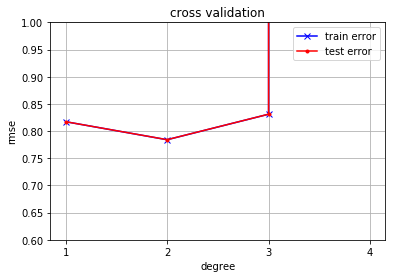

In [28]:
# Visualize
print("Test accuracy:")
print(test_accuracies)
cross_validation_visualization_degree(degree_range, train_losses, test_losses)

### Grid search for Methods using regularisation
Grid search over different degrees of polynominal expansion and for different lambdas

In [29]:
# Chose learnig method to use (see mapping above)
flag_method = 3;

# set Gradient descent parameters
gamma = 0.1
max_iters = 500

# Define range for the polynomial expansion and for lambda
degree_range = np.arange(2, 3)
lambda_range = np.arange(0.0, 1.6e-12, 2.e-13)

train_losses_matrix = np.zeros((len(degree_range), len(lambda_range)))
test_losses_matrix = np.zeros((len(degree_range), len(lambda_range)))
train_accuracies_matrix = np.zeros((len(degree_range), len(lambda_range)))
test_accuracies_matrix = np.zeros((len(degree_range), len(lambda_range)))

# Preparing data for cross validation
xtrain = remove_invalid(train_x)

for ind_degree, degree in enumerate(degree_range):
    for ind_lambda_, lambda_ in enumerate(lambda_range):
        loss_tr, loss_te , accuracy_tr, accuracy_te= cross_validation(xtrain, train_y, flag_method, degree, lambda_, gamma, max_iters)
        print("For the Degree: %d and lambda %.2E, The LOSS is : %f" %(degree, lambda_, loss_te))
        train_losses_matrix[ind_degree, ind_lambda_] = loss_tr
        test_losses_matrix[ind_degree, ind_lambda_] = loss_te
        train_accuracies_matrix[ind_degree, ind_lambda_] = accuracy_tr
        test_accuracies_matrix[ind_degree, ind_lambda_] = accuracy_te

print("Cross Validation finished!!")
best_value = np.unravel_index(np.argmin(test_losses_matrix), test_losses_matrix.shape)
print(best_value)
print("Best degree: %d, with lambda %.2E " %(degree_range[best_value[0]], lambda_range[best_value[1]]))

For the Degree: 2 and lambda 0.00E+00, The LOSS is : 0.784160
For the Degree: 2 and lambda 2.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 4.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 6.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 8.00E-13, The LOSS is : 0.784158
For the Degree: 2 and lambda 1.00E-12, The LOSS is : 0.784160
For the Degree: 2 and lambda 1.20E-12, The LOSS is : 0.784161
For the Degree: 2 and lambda 1.40E-12, The LOSS is : 0.784163
Cross Validation finished!!
(0, 2)
Best degree: 2, with lambda 4.00E-13 


Test accuracy:
[[0.787876 0.787916 0.787928 0.78792  0.787928 0.787904 0.787896 0.787924]]


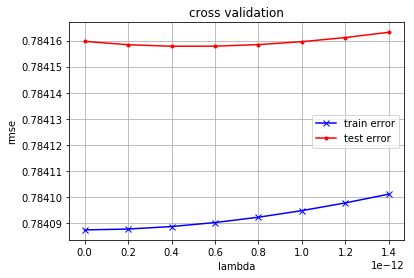

In [30]:
# Visualize
print("Test accuracy:")
print(test_accuracies_matrix)
cross_validation_visualization_lambda(lambda_range, train_losses_matrix[0, :], test_losses_matrix[0, :])